# Detailed comparison between deep and non-deep learning

## By Brecht De Boeck - on behalf of Group 10

The difference between deep learning and non-deep learning is very simple: Any neural network with at least (or according to some sources, more than) three layers is considered deep learning.

For this part of our assignment, I'll be creating two separate image classification models, one deep learning and one non-deep, and comparing the two based on both the speed at which they make a prediction, and their overall performance.

### Creating the non-deep learning models

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [2]:
#Read the basic data from the labeled dataset
data = pd.read_csv("data/swarmIoT_full_labeled_dataset.csv")
images = data["image"].str.split("-", n = 1, expand = True)
data["image"] = images[1]

Neural networks are the most obvious choice when it comes to image classification, but these generally fall under deep learning. We could try using a neural network without any hidden layers, where input and output are directly connected.

However, we have seen a lot of non-deep learning models throughout this course. Sure, none of them were explicitly used for image classification, but that doesn't mean we can't try using one of them for it. But then the question remains: which algorithm do we choose?

Our options:
- kNN: Nope. Not using this one. Not only is it way too slow, but it's pretty much undeployable, seeing as there isn't a real model that's created.
- Support Vector Machines: While an interesting choice, these kinds of models don't do very well in the way of speed and scaleability. Especially in the case of that first one, we don't want to give our neural network an unfair advantage.
- Decision Trees: Seems to be our best fit. Though it cannot actually see the images, but only their raw values, it is capable of making decisions based on the given input, similar to how a deep learning neural network would do it.
- Logistic Regression: As bizarre as it might seem, we can also use Logistic Regression if we reshape the dimensions of our training and test set to consist of at most two dimensions.

For this task, I'll be making both a Decision Tree and a Logistic Regression model. The Decision Tree (at least from my perspective) seems to lie the closest to emulating a neural network, while for Logistic Regression, I'm simply curious to find out what results the model might give us.

And finally, as discussed, I'll be making a neural network without any hidden layers. All of these models will be compared to our deep learning models made in the next chapter of this notebook.

#### Extracting features from the images

The problem with decision trees is that, of course, we can't just feed raw images to our model. The decision tree expects features with differing values, which it can then use to make splits to gain as much information gain as possible. The same goes for our Logistic Regression model: we can't just expect to be able to throw in raw image data and have the model make accurate predictions. Our first order of business is thus to create a new dataset, that combines our classifiers and their images with features we extract from the images.

In [3]:
from sklearn.cluster import MiniBatchKMeans
import time
import os

In [5]:
# The following function will be used to process every image within our dataset
def extract_features_from_image(camera, partition, img):
    st = time.time()
    path = "/".join(['data','images',camera,partition,img])
    partition_path = "/".join(['data','images',camera,partition])
    image = plt.imread(path)
    
    dicto = []
    
    if image is not None:
        #Extract features using SIFT
        sift = cv.SIFT_create()
        kp, des = sift.detectAndCompute(image,None)
        for d in des:
            dicto.append(d)
        
        k = 30
        batch_size = np.size(os.listdir(partition_path)) * 3
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dicto)
        
        histo = np.zeros(k)
        nkp = np.size(kp)
        for d in des:
            idx = kmeans.predict([d.astype(np.double)])
            histo[idx] += 1/nkp
    return histo

Using the above method should work when working with machine learning models, but we cannot use it on all of our images. That would simply be a fool's errand, clustering the keypoints of more than 6000 images. It's a good thing our images are split amongst partitions.

I'll be using the images from Camera 3, specifically the first partition, which our group labeled ourselves and only contains 856 images. I'll be taking the first 50 images from this partition and splitting it into training and test datasets. That's all the abuse I'm willing to inflict on my poor computer, even if the resulting sample won't give us nearly as much information as when working on the full dataset or even just a simple partition.

**For the Record**: Yes, I did try getting the features of an entire partition. That attempt resulted in my computer crashing. Again. I work with what I have in this assignment, so please just bare with me.

In [6]:
sample = os.listdir("data/images/3 De nayer (Loop piste)/partition 1")
sample = data.loc[data["image"].isin(sample)].head(50)

#extract_features_from_image("3 De nayer (Loop piste)", "partition 1",sample["image"].head(1).iloc[0])
#sample_feats = [extract_features_from_image("3 De nayer (Loop piste)", "partition 1", img) for img in sample["image"]]

In [ ]:
sample_feats_df = pd.DataFrame(sample_feats)

In [ ]:
sample_feats

[array([0.06378738, 0.04186047, 0.03654485, 0.03189369, 0.03853821,
        0.01960133, 0.0372093 , 0.04418605, 0.0282392 , 0.03920266,
        0.01860465, 0.03853821, 0.02425249, 0.03289037, 0.02757475,
        0.03222591, 0.02591362, 0.04186047, 0.03189369, 0.02491694,
        0.02093023, 0.03122924, 0.03654485, 0.01594684, 0.04019934,
        0.02259136, 0.05282392, 0.03421927, 0.02425249, 0.04152824]),
 array([0.04551724, 0.03517241, 0.02275862, 0.04448276, 0.04758621,
        0.02551724, 0.02793103, 0.06689655, 0.01689655, 0.03206897,
        0.0337931 , 0.02551724, 0.03206897, 0.02275862, 0.04551724,
        0.04310345, 0.02689655, 0.02517241, 0.01896552, 0.02206897,
        0.03758621, 0.02655172, 0.04241379, 0.03413793, 0.03137931,
        0.03965517, 0.02862069, 0.02655172, 0.04172414, 0.03068966]),
 array([0.01561416, 0.02741152, 0.04510756, 0.02151284, 0.05898681,
        0.01873699, 0.04024983, 0.03990285, 0.04510756, 0.02637058,
        0.03469813, 0.04614851, 0.04649549, 

In [ ]:
sample_feats_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.063787,0.041860,0.036545,0.031894,0.038538,0.019601,0.037209,0.044186,0.028239,0.039203,...,0.020930,0.031229,0.036545,0.015947,0.040199,0.022591,0.052824,0.034219,0.024252,0.041528
1,0.045517,0.035172,0.022759,0.044483,0.047586,0.025517,0.027931,0.066897,0.016897,0.032069,...,0.037586,0.026552,0.042414,0.034138,0.031379,0.039655,0.028621,0.026552,0.041724,0.030690
2,0.015614,0.027412,0.045108,0.021513,0.058987,0.018737,0.040250,0.039903,0.045108,0.026371,...,0.023942,0.021860,0.035739,0.026718,0.029146,0.060722,0.025677,0.024983,0.015267,0.045455
3,0.030602,0.021761,0.017681,0.032982,0.030942,0.028222,0.034682,0.026862,0.066984,0.044203,...,0.026522,0.038422,0.046923,0.031282,0.031962,0.034682,0.017681,0.024141,0.068004,0.025162
4,0.045194,0.024283,0.023946,0.048229,0.030691,0.031703,0.035750,0.030354,0.026981,0.027993,...,0.033390,0.035076,0.022260,0.029005,0.033052,0.067454,0.027319,0.048904,0.029005,0.027993
5,0.030753,0.052522,0.022460,0.034900,0.044229,0.022460,0.024188,0.026261,0.031790,0.031099,...,0.044229,0.039737,0.036973,0.030408,0.027643,0.043538,0.027298,0.029026,0.021424,0.046303
6,0.029282,0.040518,0.031324,0.028941,0.040518,0.032346,0.059925,0.024855,0.025536,0.044263,...,0.048689,0.023153,0.023834,0.033027,0.035410,0.026217,0.041539,0.024515,0.043582,0.026558
7,0.035423,0.031173,0.021962,0.029756,0.024088,0.024442,0.040383,0.066596,0.031881,0.035069,...,0.019837,0.046050,0.084662,0.025859,0.030818,0.025859,0.024796,0.023734,0.027630,0.025151
8,0.023305,0.079802,0.026483,0.021540,0.027542,0.032486,0.033898,0.024011,0.046963,0.030720,...,0.024364,0.045198,0.044845,0.033192,0.025777,0.030720,0.029661,0.044138,0.022246,0.022246
9,0.025321,0.079529,0.028174,0.053138,0.031027,0.024251,0.037447,0.042796,0.033167,0.024608,...,0.023538,0.016762,0.024251,0.042083,0.039586,0.028531,0.036733,0.022825,0.041369,0.033524


Another thing I'll be doing to reduce the abuse on my CPU, is saving this sample in a separate csv-file in the data-folder. This way, I won't have to re-execute this operation over and over again.

In [ ]:
sample_feats_df.to_csv('data/brecht-sample.csv')

In [14]:
from sklearn.model_selection import train_test_split

X = pd.read_csv("data/brecht-sample.csv")
Y = sample["choice"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=2)

#### The Decision Tree Model

In [15]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier()
dec_tree = dec_tree.fit(X_train, y_train)

In [16]:
start = time.time()
score = dec_tree.score(X_test, y_test)
end = time.time()

print(f"Model speed: {end - start}")
print(f"Model performance: {score}")

Model speed: 0.0019373893737792969
Model performance: 0.65


**Analysis: Decision Tree**

* Speed: Between 0.001 and 0.009 seconds to evaluate the entire test set.

* Performance: Accuracy always between 60 and 70 %.

#### The Logistic Regression Model

In [17]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg = log_reg.fit(X_train, y_train)

In [18]:
start = time.time()
score = log_reg.score(X_test, y_test)
end = time.time()

print(f"Model speed: {end - start}")
print(f"Model performance: {score}")

Model speed: 0.008014917373657227
Model performance: 0.8


**Analysis: Logistic Regression**

* Speed: Between 0.001 and 0.013 seconds, so a little slower than the Decision Tree.

* Performance: Accuracy always at 80%.

#### The "Perceptron" (non-deep neural network)

We're making use of Tensorflow early to create ourselves a Single-Layer Perceptron. Though a neural network, SLP's are considered non-deep learning due to only having one neuron layer, and are typically used for linear binary classification problems. And what better way to compare deep and non-deep learning than by having an algorithm that's at least somewhat like our deep learning models.

**Disclaimer**: If anyone disagrees with my logic and wants to debate that, because they still have at least one neuron layer, SLP's are still deep learning, you're welcome to do so.

In [26]:
# Defining the input features
sample = os.listdir("data/images/3 De nayer (Loop piste)/partition 1")
sample = data.loc[data["image"].isin(sample)].head(50)

X = np.array([cv.imread("/".join(['data','images','3 De nayer (Loop piste)','partition 1',img])) for img in sample["image"]])
Y = np.array(sample["choice"])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

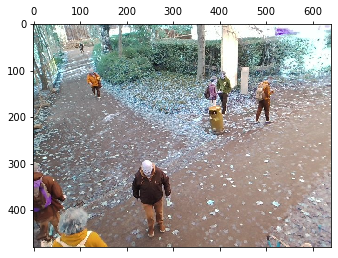

In [27]:
plt.matshow(X_train[0])

Now that we have split our datasets, we still need to normalize them, as well as flatten them in order to compute for model building. We could also accomplish this with an extra layer in our neural network, but since we're working with an SLP for non-deep learning, we'll leave that for the next chapter.

In [28]:
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train_flatten = X_train.reshape(len(X_train), 480*640*3)
X_test_flatten = X_test.reshape(len(X_test), 480*640*3)

Now that our data is ready, it's time to build, compile and fit our model.

In [29]:
#We'll be using very similar syntax later, but this is the only
#layer we'll be adding to our perceptron.
sl_perceptron = tf.keras.Sequential([
    tf.keras.layers.Dense(3, input_shape=(921600,), activation='sigmoid')
])

When compiling our model, I played around with the various fit-parameters to ensure the least likelihood of overfitting. Despite this, I'm quite sure we're still overfitting in all of our neural networks.

It is my belief that the cause of this is the small size of the training set. It only contains 30 images, after all, which is not a lot to go on. The choice for this small training set is related to the fact the rest of the non-deep learning models also had to use such a small dataset, as saving too many image features was likely going to result in my computer crashing over and over. Because these models are also important in regards to our comparison, I didn't want to give the neural networks an unfair advantage.

In [30]:
sl_perceptron.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

sl_perceptron.fit(X_train_flatten, Y_train, epochs=15, batch_size = 3, validation_split=0.4)

Epoch 1/15
6/6 [==============================] - 1s 66ms/step - loss: 397.7948 - accuracy: 0.3889 - val_loss: 352.4139 - val_accuracy: 0.6667
Epoch 2/15
6/6 [==============================] - 0s 41ms/step - loss: 347.1820 - accuracy: 0.6667 - val_loss: 188.4951 - val_accuracy: 0.1667
Epoch 3/15
6/6 [==============================] - 0s 47ms/step - loss: 188.2887 - accuracy: 0.5000 - val_loss: 170.5765 - val_accuracy: 0.6667
Epoch 4/15
6/6 [==============================] - 0s 42ms/step - loss: 196.5474 - accuracy: 0.5000 - val_loss: 189.5586 - val_accuracy: 0.6667
Epoch 5/15
6/6 [==============================] - 0s 39ms/step - loss: 201.0564 - accuracy: 0.6667 - val_loss: 126.1700 - val_accuracy: 0.1667
Epoch 6/15
6/6 [==============================] - 0s 40ms/step - loss: 65.1961 - accuracy: 0.5000 - val_loss: 158.7215 - val_accuracy: 0.1667
Epoch 7/15
6/6 [==============================] - 0s 48ms/step - loss: 195.1481 - accuracy: 0.5556 - val_loss: 195.4097 - val_accuracy: 0.2500


In [33]:
start = time.time()
score = sl_perceptron.evaluate(X_test_flatten, Y_test)
end = time.time()

print(f"Model speed: {end - start}")
print(f"Model performance: {score[1]}")

1/1 [==============================] - 0s 39ms/step - loss: 12.4246 - accuracy: 0.7500
Model speed: 0.11099600791931152
Model performance: 0.75


**Analysis: Single-Layer Perceptron**

* Speed: A little over 0.1 second. This is mainly attributable to the amount of training

* Performance: Accuracy of 75% or 80%, either worse than or the same as our Logistic Regression-model. It depends on how the data is split, I believe, as both results have popped up.

### Deep-learning neural networks

Any machine learning model is considered deep learning if it has at least three layers total. This includes input layers, output layers and the hidden layers in between.

When it comes to computer vision, neural networks have become the preferred option. I'll be making several neural networks with varying numbers of hidden layers. This is to test the impact an increasing number of layers has on the speed and performance of the model.

It wouldn't be an analysis if I didn't have an initial hypothesis: I'm going to start off from the viewpoint that the performance of our model will be directly proportional to the total number of hidden layers, while our speed will be inversely proportional to it. In other words: the more layers, the better our model performs, but the longer it will take to make a prediction. 

In [34]:
from sklearn.model_selection import train_test_split

#Well, what are we waiting for? Let's load in our data and get analyzing!
sample = os.listdir("data/images/3 De nayer (Loop piste)/partition 1")
sample = data.loc[data["image"].isin(sample)].head(50)

In [35]:
#Our X will contain the pixels of our loaded images, while our Y contains all of the classifiers
X = np.array([cv.imread("/".join(['data','images','3 De nayer (Loop piste)','partition 1',img])) for img in sample["image"]])
Y = np.array(sample["choice"])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

Our training set consists of 30 images, each of which consist of 480 x 640 BRG-pixels.

In [36]:
X_train.shape

(30, 480, 640, 3)

In [37]:
len(Y_train)

30

In [38]:
Y_train

array([2., 2., 2., 2., 0., 2., 2., 1., 2., 2., 0., 2., 1., 1., 0., 2., 2.,
       2., 0., 2., 2., 2., 2., 2., 1., 2., 0., 2., 1., 2.])

In [39]:
X_train = X_train / 255.0
X_test = X_test / 255.0

#### The models I made

* First Model: Consists of 3 layers, including input and output. The only hidden layer here is the relu-layer, while the final Dense-layer represents our output.
* Second Model: Consists of 5 layers, including input and output, for a total of 5 hidden layers.
* Third Model: Consists of 7 layers, including input and output, for a total of 5 hidden layers.

In [40]:
first_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(480,640,3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

second_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(480,640,3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

third_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(480,640,3)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

In essence, my first model is nothing more than essentially our Logistic Regression-model from earlier converted into a neural network.

In [41]:
first_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

first_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 921600)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               117964928 
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 117,965,315
Trainable params: 117,965,315
Non-trainable params: 0
_________________________________________________________________


In [42]:
first_model.fit(X_train, Y_train, epochs=15, batch_size = 3, validation_split=0.4)

Epoch 1/15
6/6 [==============================] - 6s 906ms/step - loss: 347.5518 - accuracy: 0.5000 - val_loss: 89.2314 - val_accuracy: 0.6667
Epoch 2/15
6/6 [==============================] - 5s 881ms/step - loss: 76.7222 - accuracy: 0.2222 - val_loss: 53.0516 - val_accuracy: 0.1667
Epoch 3/15
6/6 [==============================] - 5s 884ms/step - loss: 43.7542 - accuracy: 0.6111 - val_loss: 23.5213 - val_accuracy: 0.6667
Epoch 4/15
6/6 [==============================] - 5s 909ms/step - loss: 34.0194 - accuracy: 0.3333 - val_loss: 19.0535 - val_accuracy: 0.6667
Epoch 5/15
6/6 [==============================] - 6s 954ms/step - loss: 31.3795 - accuracy: 0.5000 - val_loss: 33.5701 - val_accuracy: 0.1667
Epoch 6/15
6/6 [==============================] - 6s 964ms/step - loss: 28.2248 - accuracy: 0.6667 - val_loss: 21.0162 - val_accuracy: 0.6667
Epoch 7/15
6/6 [==============================] - 5s 872ms/step - loss: 16.5338 - accuracy: 0.5000 - val_loss: 17.7080 - val_accuracy: 0.1667
Epoch

In [56]:
start = time.time()
score = first_model.evaluate(X_test, Y_test)
end = time.time()

print(f"Model speed: {end - start}")
print(f"Model performance: {score[1]}")

1/1 [==============================] - 0s 67ms/step - loss: 7.3970 - accuracy: 0.7500
Model speed: 0.13718962669372559
Model performance: 0.75


**Analysis: Deep Learning Neural Network including 3 hidden layers**

* Speed: Between 0.136 and 0.160 seconds, slightly slower than our Single-Layer Perceptron
* Performance: Accuracy is always at 75%, either the same or slightly *worse* as our non-deep learning Single-Layer Perceptron. 

In [57]:
second_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

second_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 921600)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               117964928 
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                                 
Total params: 117,975,363
Trainable params: 117,975,363
Non-trainable params: 0
_________________________________________________________________


In [58]:
second_model.fit(X_train, Y_train, epochs=15, batch_size = 3, validation_split=0.4)

Epoch 1/15
6/6 [==============================] - 6s 931ms/step - loss: 116.5125 - accuracy: 0.6667 - val_loss: 27.1247 - val_accuracy: 0.6667
Epoch 2/15
6/6 [==============================] - 5s 895ms/step - loss: 25.5688 - accuracy: 0.5556 - val_loss: 15.4014 - val_accuracy: 0.1667
Epoch 3/15
6/6 [==============================] - 5s 912ms/step - loss: 24.9387 - accuracy: 0.4444 - val_loss: 33.0972 - val_accuracy: 0.1667
Epoch 4/15
6/6 [==============================] - 5s 882ms/step - loss: 27.3574 - accuracy: 0.4444 - val_loss: 40.9964 - val_accuracy: 0.1667
Epoch 5/15
6/6 [==============================] - 5s 894ms/step - loss: 36.1449 - accuracy: 0.5000 - val_loss: 57.4611 - val_accuracy: 0.6667
Epoch 6/15
6/6 [==============================] - 5s 891ms/step - loss: 43.1998 - accuracy: 0.6667 - val_loss: 24.9207 - val_accuracy: 0.1667
Epoch 7/15
6/6 [==============================] - 5s 889ms/step - loss: 33.0309 - accuracy: 0.2222 - val_loss: 15.2462 - val_accuracy: 0.6667
Epoch

In [67]:
start = time.time()
score = second_model.evaluate(X_test, Y_test)
end = time.time()

print(f"Model speed: {end - start}")
print(f"Model performance: {score[1]}")

1/1 [==============================] - 0s 66ms/step - loss: 3.3173 - accuracy: 0.7500
Model speed: 0.14200067520141602
Model performance: 0.75


**Analysis: Deep Learning Neural Network including 5 hidden layers**
* Speed: Between 0.1 and 0.2 seconds, the same speed as our previous neural network.
* Performance: Accuracy of about 75% or 80%, the same performance we saw from our Single-Layer Perceptron. Even with the extra layers, our performance hasn't changed at all.

It does, however, depend on the data used. In a previous attempt, before the pixel-values of our images were converted to values between 0 and 1, our second model actually performed *worse* than not just our first model, but also every single one of our non-deep learning models. The performance of a neural network, therefore, is not just dependent on the structure of its layers, but also on the data fed into its inputs.

The third model is a little special: rather than adding new densely-connected neuron layers, we instead placed two Dropout-layers in between them, effectively performing a sort of regularization. By switching off our neurons, we'll be able to effectively reduce any overfitting our model might be doing. Besides that, I've increased the number of neurons for each densely-connected layer in the network, aside from the last one.

In [68]:
third_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

third_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 921600)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               235929856 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 3)                

In [69]:
third_model.fit(X_train, Y_train, epochs=15, batch_size = 3, validation_split=0.4)

Epoch 1/15
6/6 [==============================] - 13s 2s/step - loss: 86.7182 - accuracy: 0.6667 - val_loss: 25.7861 - val_accuracy: 0.6667
Epoch 2/15
6/6 [==============================] - 12s 2s/step - loss: 40.5672 - accuracy: 0.4444 - val_loss: 11.9520 - val_accuracy: 0.6667
Epoch 3/15
6/6 [==============================] - 12s 2s/step - loss: 19.8094 - accuracy: 0.6111 - val_loss: 19.6645 - val_accuracy: 0.1667
Epoch 4/15
6/6 [==============================] - 12s 2s/step - loss: 22.6666 - accuracy: 0.3889 - val_loss: 15.3978 - val_accuracy: 0.6667
Epoch 5/15
6/6 [==============================] - 12s 2s/step - loss: 34.9953 - accuracy: 0.6111 - val_loss: 28.7610 - val_accuracy: 0.6667
Epoch 6/15
6/6 [==============================] - 12s 2s/step - loss: 28.9180 - accuracy: 0.5556 - val_loss: 14.5742 - val_accuracy: 0.6667
Epoch 7/15
6/6 [==============================] - 12s 2s/step - loss: 38.8459 - accuracy: 0.3333 - val_loss: 22.7235 - val_accuracy: 0.6667
Epoch 8/15
6/6 [====

In [73]:
start = time.time()
score = third_model.evaluate(X_test, Y_test)
end = time.time()

print(f"Model speed: {end - start}")
print(f"Model performance: {score[1]}")

1/1 [==============================] - 0s 95ms/step - loss: 1.5215 - accuracy: 0.7500
Model speed: 0.16297292709350586
Model performance: 0.75


**Analysis: Deep learning neural network including 7 hidden layers, among which Dropout-layers**

* Speed: Between 0.163 and 0.27 seconds.

* Performance: Accuracy is always 75%. It appears that, although we reduced the chance of overfitting, we seem to be performing worse than our SLP and the previous neural network.

### Conclusions

* Depending on what options you give to a deep learning model during training, this model could perform better than a non-deep learning model, though this does not have to be the case. Our best deep learning model had the same performance as both Logistic Regression and the SLP, both of which were non-deep learning, though it was also a lot slower while making its predictions.
* Deep learning models with more layers don't necessarily always perform better than those with fewer layers. It depends on many other aspects of the model as well, such as the amount of neurons per layer, the activation function per layer, number of dropout layers, batch size and validation rate while fitting the model and, of course, the data within the training set. Sometimes a deep learning model with more layers has a better accuracy than another model with fewer layers, sometimes it performs worse.
* The way the data fed into a neural network is structured plays a big role in determining the overall accuracy of a neural network when classifying images.